In [1]:
%pip install ultralytics
%pip install opencv-python
%pip install pillow
%pip install matplotlib
%pip install seaborn
%pip install tensorboard
%pip install albumentations
%pip install pyyaml
%pip install tensorflow
%pip install tensorflow-lite

print("✓ All packages installed successfully!")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached ml_dtypes-0.4.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
Using cached ml_dtypes-0.4.1-cp312-cp312-win_amd64.whl (127 kB)
Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl (15.5 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 2.2.6

    Uninstalling numpy-2.2.6:

   ---------------------------------------- 0/2 [numpy]
   ---------------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnx 1.19.1 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
onnxslim 0.1.71 requires sympy>=1.13.3, but you have sympy 1.13.1 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


Note: you may need to restart the kernel to use updated packages.
✓ All packages installed successfully!


ERROR: Could not find a version that satisfies the requirement tensorflow-lite (from versions: none)
ERROR: No matching distribution found for tensorflow-lite


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
import shutil
import yaml
from collections import Counter
import albumentations as A
from PIL import Image
import random
import json
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


ERROR! Session/line number was not unique in database. History logging moved to new session 527


In [2]:
from pathlib import Path

# Your actual dataset path
DATASET_PATH = Path(r"D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages")
IMAGES_DIR = DATASET_PATH / "images"
LABELS_DIR = DATASET_PATH / "labels"
CLASSES_FILE = DATASET_PATH / "classes.txt"
NOTES_FILE = DATASET_PATH / "notes.json"

print(f"Dataset path: {DATASET_PATH}")
print(f"Images directory: {IMAGES_DIR}")
print(f"Labels directory: {LABELS_DIR}")

# Verify dataset exists
assert IMAGES_DIR.exists(), f"❌ Images directory not found: {IMAGES_DIR}"
assert LABELS_DIR.exists(), f"❌ Labels directory not found: {LABELS_DIR}"

# Count images with ALL formats (.jpg, .jpeg, .png)
num_jpg = len(list(IMAGES_DIR.glob("*.jpg")))
num_jpeg = len(list(IMAGES_DIR.glob("*.jpeg")))
num_png = len(list(IMAGES_DIR.glob("*.png")))
num_images = num_jpg + num_jpeg + num_png

# Count labels
num_labels = len(list(LABELS_DIR.glob("*.txt")))

print(f"\n✓ Dataset found!")
print(f"  - JPG files: {num_jpg}")
print(f"  - JPEG files: {num_jpeg}")
print(f"  - PNG files: {num_png}")
print(f"  - Total images: {num_images}")
print(f"  - Total labels: {num_labels}")

if num_images == num_labels:
    print(f"\n✓ Perfect match! Images and labels are synchronized.")
else:
    print(f"\n⚠ Mismatch: {abs(num_images - num_labels)} files don't match")

# Load and display classes
if CLASSES_FILE.exists():
    with open(CLASSES_FILE, 'r') as f:
        classes = [line.strip() for line in f.readlines()]
    print(f"\n✓ Classes loaded ({len(classes)} classes):")
    for idx, cls in enumerate(classes):
        print(f"  {idx}: {cls}")
else:
    print(f"\n⚠ Classes file not found: {CLASSES_FILE}")

# Load and display notes if available
if NOTES_FILE.exists():
    with open(NOTES_FILE, 'r') as f:
        notes = json.load(f)
    print(f"\n✓ Dataset notes:")
    for key, value in notes.items():
        print(f"  {key}: {value}")


Dataset path: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages
Images directory: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\images
Labels directory: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\labels

✓ Dataset found!
  - JPG files: 1012
  - JPEG files: 28
  - PNG files: 4
  - Total images: 1044
  - Total labels: 1044

✓ Perfect match! Images and labels are synchronized.

✓ Classes loaded (4 classes):
  0: ArtScience Museum
  1: Esplanade
  2: Marina Bay Sands
  3: Merlion

✓ Dataset notes:
  categories: [{'id': 0, 'name': 'ArtScience Museum'}, {'id': 1, 'name': 'Esplanade'}, {'id': 2, 'name': 'Marina Bay Sands'}, {'id': 3, 'name': 'Merlion'}]
  info: {'year': 2025, 'version': '1.0', 'contributor': 'Label Studio'}


Total objects annotated: 1499

Class distribution:
  Class 0: 459 objects (30.6%)
  Class 1: 174 objects (11.6%)
  Class 2: 570 objects (38.0%)
  Class 3: 296 objects (19.7%)


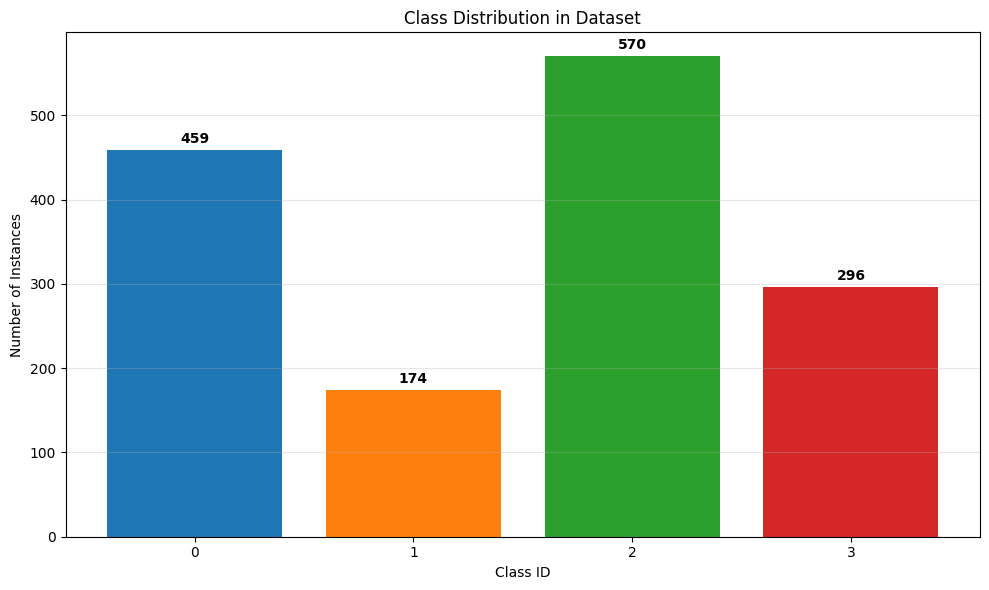

✓ Class distribution analyzed and visualized successfully!


In [3]:
# Cell 4: Analyze class distribution (handles mixed image formats)
from collections import Counter

class_counts = Counter()
total_objects = 0

for label_file in LABELS_DIR.glob("*.txt"):
    with open(label_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.strip():
                class_id = int(line.split()[0])
                class_counts[class_id] += 1
                total_objects += 1

print(f"Total objects annotated: {total_objects}")
print(f"\nClass distribution:")
for class_id in sorted(class_counts.keys()):
    count = class_counts[class_id]
    percentage = (count / total_objects) * 100
    print(f"  Class {class_id}: {count} objects ({percentage:.1f}%)")

# Visualize class distribution
plt.figure(figsize=(10, 6))
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(classes)]
plt.bar(classes, counts, color=colors)
plt.xlabel('Class ID')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in Dataset')
plt.xticks(classes)
for i, v in enumerate(counts):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("✓ Class distribution analyzed and visualized successfully!")

Total images found: 1044


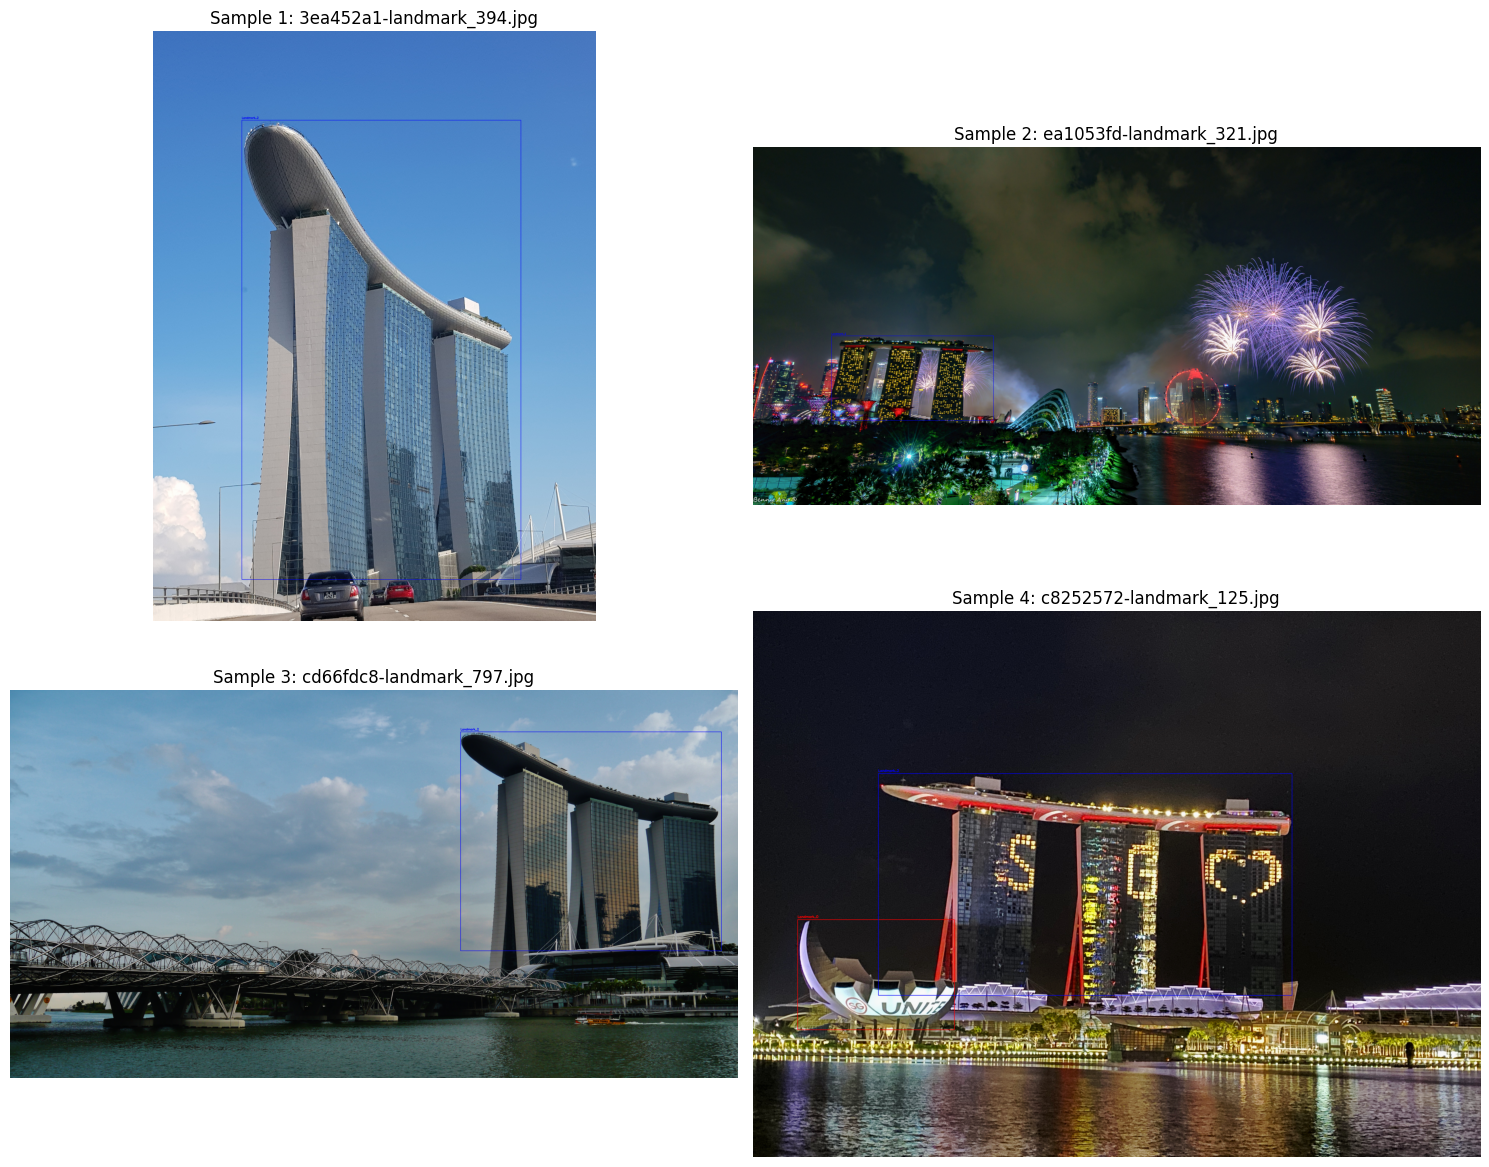


✓ Sample visualization complete!


In [4]:
# Cell 5: Visualize sample images with annotations
import random

def visualize_yolo_annotations(image_path, label_path, class_names):
    """Visualize YOLO format annotations on image"""
    img = cv2.imread(str(image_path))
    if img is None:
        print(f"⚠ Could not read image: {image_path}")
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    with open(label_path, 'r') as f:
        for line in f.readlines():
            if line.strip():
                class_id, x_center, y_center, width, height = map(float, line.split())
                class_id = int(class_id)
                
                # Convert YOLO format to pixel coordinates
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)
                
                # Clamp coordinates to image bounds
                x1 = max(0, min(x1, w-1))
                y1 = max(0, min(y1, h-1))
                x2 = max(0, min(x2, w-1))
                y2 = max(0, min(y2, h-1))
                
                # Draw bounding box
                color = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)][class_id % 4]
                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                
                # Add label
                label = f"{class_names.get(class_id, f'Class {class_id}')}"
                cv2.putText(img, label, (x1, y1 - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return img

# Define your class names (update these with your actual landmark names)
CLASS_NAMES = {
    0: 'Landmark_0',
    1: 'Landmark_1',
    2: 'Landmark_2',
    3: 'Landmark_3'
}

# Get all images with mixed formats
all_images = (list(IMAGES_DIR.glob("*.jpg")) + 
              list(IMAGES_DIR.glob("*.jpeg")) + 
              list(IMAGES_DIR.glob("*.png")))

print(f"Total images found: {len(all_images)}")

# Show 4 random samples
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

sample_images = random.sample(all_images, min(4, len(all_images)))

for idx, img_path in enumerate(sample_images):
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    
    if label_path.exists():
        annotated_img = visualize_yolo_annotations(img_path, label_path, CLASS_NAMES)
        if annotated_img is not None:
            axes[idx].imshow(annotated_img)
            axes[idx].set_title(f"Sample {idx+1}: {img_path.name}")
            axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f"No label for\n{img_path.name}", 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Sample visualization complete!")


In [8]:
# Cell 6: Data Augmentation Pipeline using Albumentations (FINAL CORRECTED)
import albumentations as A
import os
from pathlib import Path
import shutil

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Create augmented dataset directory
AUGMENTED_DIR = DATASET_PATH / "augmented_images"
AUGMENTED_LABELS_DIR = DATASET_PATH / "augmented_labels"

# Clean and create directories
for directory in [AUGMENTED_DIR, AUGMENTED_LABELS_DIR]:
    if directory.exists():
        shutil.rmtree(directory)
    directory.mkdir(parents=True, exist_ok=True)

print(f"✓ Created augmentation directories")
print(f"  - Images: {AUGMENTED_DIR}")
print(f"  - Labels: {AUGMENTED_LABELS_DIR}")

# Define augmentation pipeline with rotation, shearing, and other techniques
augmentation_pipeline = A.Compose([
    # Geometric transformations (as per DigitalOcean tutorial)
    A.Rotate(limit=25, p=0.7, border_mode=cv2.BORDER_REFLECT),
    A.Affine(shear=(-15, 15), p=0.7, mode=cv2.BORDER_REFLECT),
    A.Perspective(scale=(0.05, 0.1), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    
    # Color/brightness augmentations
    A.GaussNoise(p=0.3),
    A.Blur(blur_limit=3, p=0.3),  # ✓ CORRECTED: Blur instead of GaussBlur
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    
    # Dropout/Cutout
    A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.3),
    
    # Elastic deformation
    A.ElasticTransform(alpha=30, sigma=5, p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))

print("\n✓ Augmentation pipeline configured with:")
print("  - Rotation (±25°)")
print("  - Shearing (±15°)")
print("  - Perspective transforms")
print("  - Horizontal & Vertical Flips")
print("  - Color augmentations (Noise, Blur, Brightness/Contrast, Hue/Saturation)")
print("  - Dropout/Cutout and elastic deformations")

# Function to convert YOLO format to list for albumentations
def read_yolo_labels(label_path):
    """Read YOLO format labels and return as list of tuples"""
    bboxes = []
    class_labels = []
    
    with open(label_path, 'r') as f:
        for line in f.readlines():
            if line.strip():
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                bboxes.append([x_center, y_center, width, height])
                class_labels.append(class_id)
    
    return bboxes, class_labels

# Function to write augmented labels back to YOLO format
def write_yolo_labels(label_path, bboxes, class_labels):
    """Write augmented bounding boxes back to YOLO format"""
    with open(label_path, 'w') as f:
        for bbox, class_id in zip(bboxes, class_labels):
            x_center, y_center, width, height = bbox
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Augmentation parameters
AUGMENTATIONS_PER_IMAGE = 3
AUGMENTATION_PROBABILITY = 0.8

print(f"\nAugmentation Configuration:")
print(f"  - Augmentations per image: {AUGMENTATIONS_PER_IMAGE}")
print(f"  - Augmentation probability: {AUGMENTATION_PROBABILITY}")

# Get all original images
original_images = (list(IMAGES_DIR.glob("*.jpg")) + 
                  list(IMAGES_DIR.glob("*.jpeg")) + 
                  list(IMAGES_DIR.glob("*.png")))

print(f"\nProcessing {len(original_images)} images...")

# Copy original images and labels to augmented directory
for img_path in original_images:
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    shutil.copy(img_path, AUGMENTED_DIR / img_path.name)
    if label_path.exists():
        shutil.copy(label_path, AUGMENTED_LABELS_DIR / f"{img_path.stem}.txt")

print(f"✓ Copied {len(original_images)} original images and labels")

# Generate augmented images
augmentation_count = 0

for img_idx, img_path in enumerate(original_images):
    label_path = LABELS_DIR / f"{img_path.stem}.txt"
    
    if not label_path.exists():
        continue
    
    image = cv2.imread(str(img_path))
    if image is None:
        print(f"⚠ Could not read image: {img_path}")
        continue
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bboxes, class_labels = read_yolo_labels(label_path)
    
    if not bboxes:
        continue
    
    for aug_num in range(AUGMENTATIONS_PER_IMAGE):
        try:
            augmented = augmentation_pipeline(
                image=image,
                bboxes=bboxes,
                class_labels=class_labels
            )
            
            aug_image = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_class_labels = augmented['class_labels']
            
            if not aug_bboxes:
                continue
            
            aug_img_name = f"{img_path.stem}_aug_{aug_num}.png"
            aug_img_path = AUGMENTED_DIR / aug_img_name
            aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(str(aug_img_path), aug_image_bgr)
            
            aug_label_path = AUGMENTED_LABELS_DIR / f"{img_path.stem}_aug_{aug_num}.txt"
            write_yolo_labels(aug_label_path, aug_bboxes, aug_class_labels)
            
            augmentation_count += 1
            
        except Exception as e:
            print(f"⚠ Error augmenting {img_path.name}: {str(e)}")
            continue
    
    if (img_idx + 1) % 100 == 0:
        print(f"  Processed {img_idx + 1}/{len(original_images)} images...")

print(f"\n✓ Augmentation complete!")
print(f"  - Augmented images created: {augmentation_count}")

# Count final dataset
final_images = len(list(AUGMENTED_DIR.glob("*.png")) + 
                   list(AUGMENTED_DIR.glob("*.jpg")) + 
                   list(AUGMENTED_DIR.glob("*.jpeg")))
final_labels = len(list(AUGMENTED_LABELS_DIR.glob("*.txt")))

print(f"\n📊 Dataset Expansion Summary:")
print(f"  - Original images: {len(original_images)}")
print(f"  - Augmented images: {augmentation_count}")
print(f"  - Total images (original + augmented): {final_images}")
print(f"  - Total labels: {final_labels}")
print(f"  - Expansion ratio: {final_images / len(original_images):.2f}x")


✓ Created augmentation directories
  - Images: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\augmented_images
  - Labels: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\augmented_labels

✓ Augmentation pipeline configured with:
  - Rotation (±25°)
  - Shearing (±15°)
  - Perspective transforms
  - Horizontal & Vertical Flips
  - Color augmentations (Noise, Blur, Brightness/Contrast, Hue/Saturation)
  - Dropout/Cutout and elastic deformations

Augmentation Configuration:
  - Augmentations per image: 3
  - Augmentation probability: 0.8

Processing 1044 images...
✓ Copied 1044 original images and labels
  Processed 100/1044 images...
  Processed 200/1044 images...
  Processed 300/1044 images...
  Processed 400/1044 images...
  Processed 500/1044 images...
  Processed 600/1044 images...
  Processed 700/1044 images...
  Processed 800/1044 images...
  Processed 900/1044 images...
  Processed 1000/1044 images...

✓ Augmentation complete!


Generating augmentation comparison visualizations...



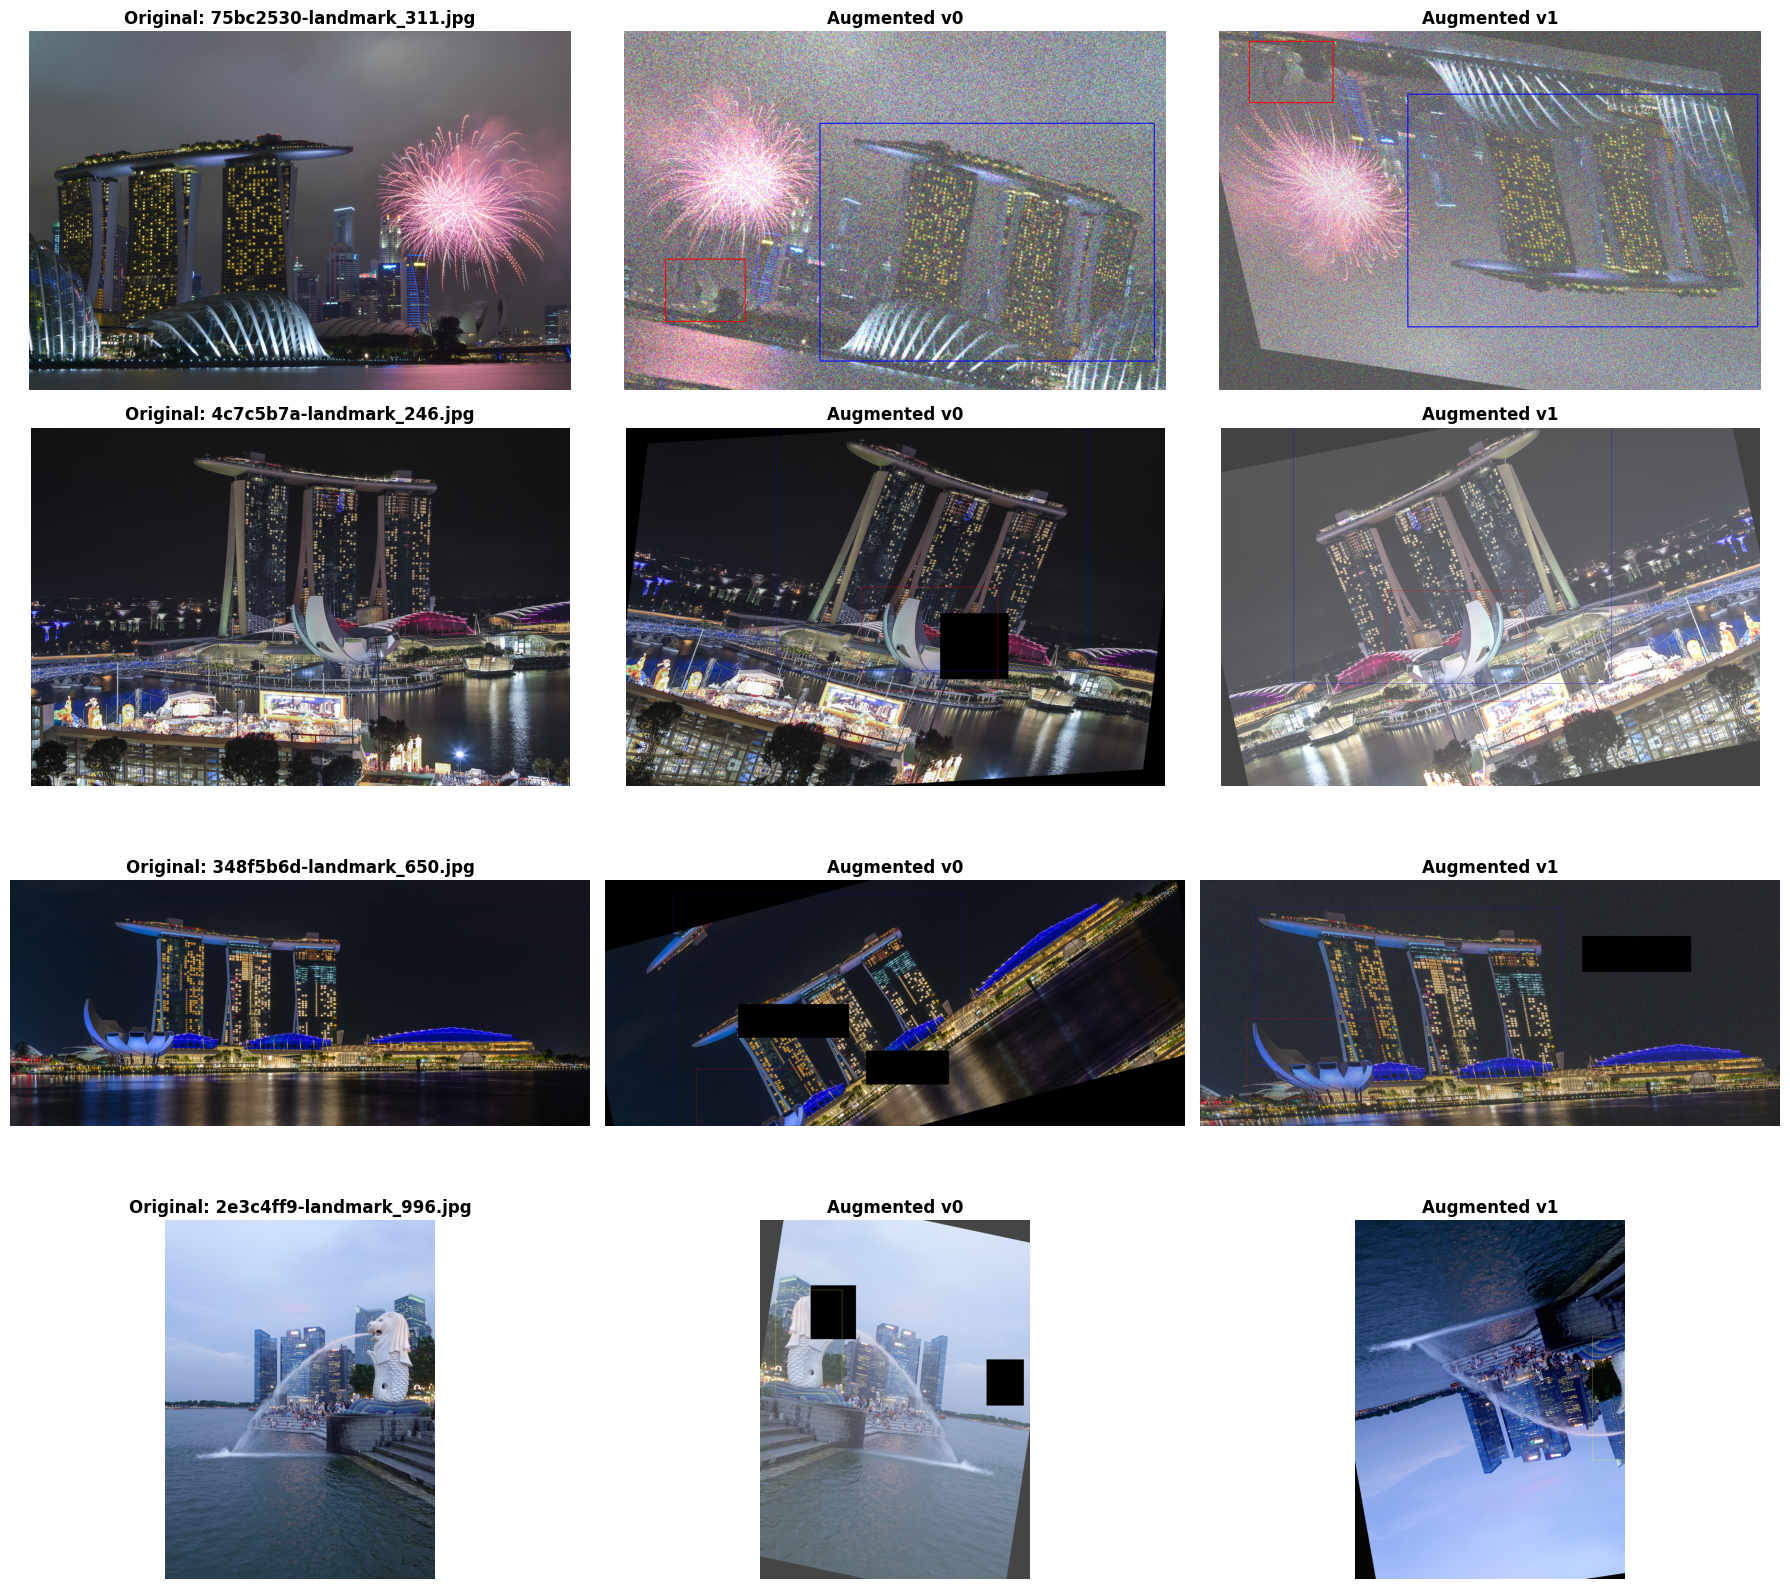

✓ Augmentation comparison visualization complete!

AUGMENTED DATASET ANALYSIS

Original Dataset:
  Class 0: 459 objects (30.6%)
  Class 1: 174 objects (11.6%)
  Class 2: 570 objects (38.0%)
  Class 3: 296 objects (19.7%)
  Total: 1499 objects

Augmented Dataset:
  Class 0: 1815 objects (30.5%)
  Class 1: 697 objects (11.7%)
  Class 2: 2286 objects (38.4%)
  Class 3: 1157 objects (19.4%)
  Total: 5955 objects

📊 Overall Statistics:
  Original objects: 1499
  Augmented objects: 5955
  Increase: 4456 objects (+297.3%)


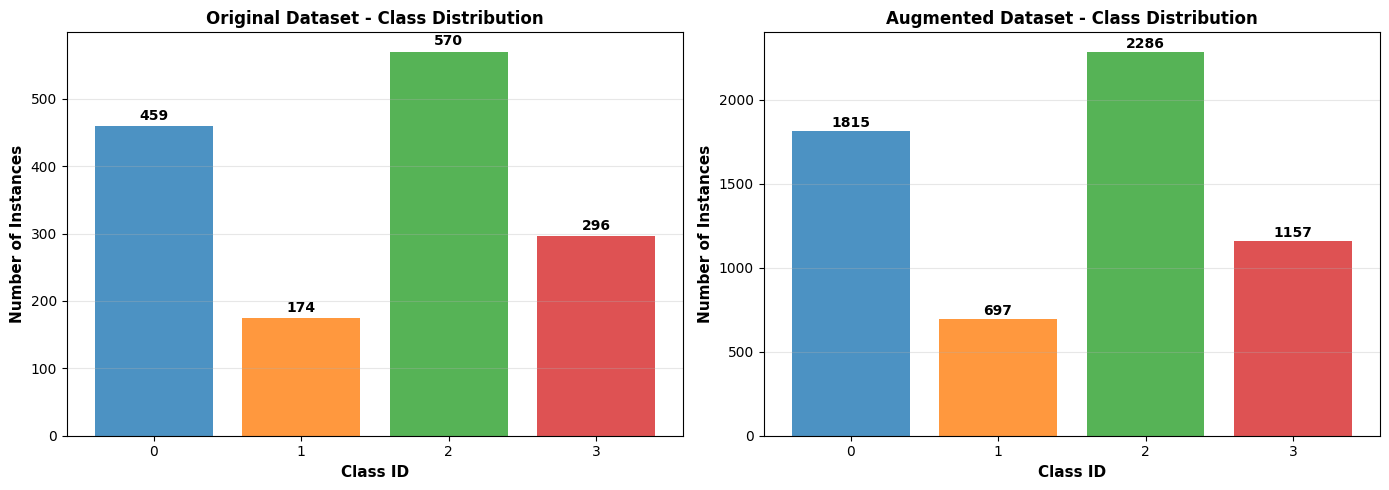


✓ Class distribution comparison complete!


In [10]:
# Cell 7: Visualize Augmented Data and Compare with Original

# Function to display original vs augmented samples
def visualize_augmentation_comparison(original_images_dir, augmented_images_dir, 
                                     original_labels_dir, augmented_labels_dir,
                                     class_names, num_comparisons=4):
    """
    Display side-by-side comparison of original and augmented images
    """
    original_images = (list(original_images_dir.glob("*.jpg")) + 
                      list(original_images_dir.glob("*.jpeg")) + 
                      list(original_images_dir.glob("*.png")))
    
    # Select random original images
    sample_originals = random.sample(original_images, min(num_comparisons, len(original_images)))
    
    fig, axes = plt.subplots(num_comparisons, 3, figsize=(18, 4*num_comparisons))
    
    for row_idx, orig_img_path in enumerate(sample_originals):
        # Original image
        orig_img = cv2.imread(str(orig_img_path))
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        orig_label_path = original_labels_dir / f"{orig_img_path.stem}.txt"
        
        # Display original
        axes[row_idx, 0].imshow(orig_img)
        axes[row_idx, 0].set_title(f"Original: {orig_img_path.name}", fontweight='bold')
        axes[row_idx, 0].axis('off')
        
        # Draw original annotations
        if orig_label_path.exists():
            h, w = orig_img.shape[:2]
            with open(orig_label_path, 'r') as f:
                for line in f.readlines():
                    if line.strip():
                        class_id, x_center, y_center, width, height = map(float, line.split())
                        class_id = int(class_id)
                        
                        x1 = int((x_center - width / 2) * w)
                        y1 = int((y_center - height / 2) * h)
                        x2 = int((x_center + width / 2) * w)
                        y2 = int((y_center + height / 2) * h)
                        
                        color = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)][class_id % 4]
                        cv2.rectangle(orig_img, (x1, y1), (x2, y2), color, 2)
        
        # Find and display augmented versions (columns 1 and 2)
        for col_idx in range(1, 3):
            aug_num = col_idx - 1
            aug_img_name = f"{orig_img_path.stem}_aug_{aug_num}.png"
            aug_img_path = augmented_images_dir / aug_img_name
            aug_label_path = augmented_labels_dir / f"{orig_img_path.stem}_aug_{aug_num}.txt"
            
            if aug_img_path.exists():
                aug_img = cv2.imread(str(aug_img_path))
                aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
                
                # Draw annotations on augmented image
                if aug_label_path.exists():
                    h, w = aug_img.shape[:2]
                    with open(aug_label_path, 'r') as f:
                        for line in f.readlines():
                            if line.strip():
                                class_id, x_center, y_center, width, height = map(float, line.split())
                                class_id = int(class_id)
                                
                                x1 = int((x_center - width / 2) * w)
                                y1 = int((y_center - height / 2) * h)
                                x2 = int((x_center + width / 2) * w)
                                y2 = int((y_center + height / 2) * h)
                                
                                color = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)][class_id % 4]
                                cv2.rectangle(aug_img, (x1, y1), (x2, y2), color, 2)
                
                axes[row_idx, col_idx].imshow(aug_img)
                axes[row_idx, col_idx].set_title(f"Augmented v{aug_num}", fontweight='bold')
            else:
                axes[row_idx, col_idx].text(0.5, 0.5, 'Augmented\nNot Found', 
                                           ha='center', va='center', transform=axes[row_idx, col_idx].transAxes)
                axes[row_idx, col_idx].set_title(f"Augmented v{aug_num} (Missing)")
            
            axes[row_idx, col_idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
print("Generating augmentation comparison visualizations...\n")
visualize_augmentation_comparison(IMAGES_DIR, AUGMENTED_DIR, 
                                 LABELS_DIR, AUGMENTED_LABELS_DIR,
                                 CLASS_NAMES, num_comparisons=4)

print("✓ Augmentation comparison visualization complete!")

# Cell 7b: Analyze augmented class distribution (CORRECTED)
print("\n" + "="*60)
print("AUGMENTED DATASET ANALYSIS")
print("="*60)

class_counts_original = Counter()
class_counts_augmented = Counter()

# Count original
for label_file in LABELS_DIR.glob("*.txt"):
    with open(label_file, 'r') as f:
        for line in f.readlines():
            if line.strip():
                parts = line.strip().split()
                class_id = int(float(parts[0]))  # ✓ Convert to float first, then int
                class_counts_original[class_id] += 1

# Count augmented - CORRECTED to handle float class IDs from Albumentations
for label_file in AUGMENTED_LABELS_DIR.glob("*.txt"):
    with open(label_file, 'r') as f:
        for line in f.readlines():
            if line.strip():
                parts = line.strip().split()
                class_id = int(float(parts[0]))  # ✓ Convert to float first, then int
                class_counts_augmented[class_id] += 1

print(f"\nOriginal Dataset:")
total_original = sum(class_counts_original.values())
for class_id in sorted(class_counts_original.keys()):
    count = class_counts_original[class_id]
    percentage = (count / total_original) * 100
    print(f"  Class {class_id}: {count} objects ({percentage:.1f}%)")
print(f"  Total: {total_original} objects")

print(f"\nAugmented Dataset:")
total_augmented = sum(class_counts_augmented.values())
for class_id in sorted(class_counts_augmented.keys()):
    count = class_counts_augmented[class_id]
    percentage = (count / total_augmented) * 100
    print(f"  Class {class_id}: {count} objects ({percentage:.1f}%)")
print(f"  Total: {total_augmented} objects")

print(f"\n📊 Overall Statistics:")
print(f"  Original objects: {total_original}")
print(f"  Augmented objects: {total_augmented}")
print(f"  Increase: {total_augmented - total_original} objects (+{((total_augmented / total_original) - 1) * 100:.1f}%)")

# Visualize class distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
classes = sorted(class_counts_original.keys())
counts_orig = [class_counts_original[c] for c in classes]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(classes)]

axes[0].bar(classes, counts_orig, color=colors, alpha=0.8)
axes[0].set_xlabel('Class ID', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Instances', fontsize=11, fontweight='bold')
axes[0].set_title('Original Dataset - Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_xticks(classes)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(counts_orig):
    axes[0].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

# Augmented distribution
counts_aug = [class_counts_augmented[c] for c in classes]
axes[1].bar(classes, counts_aug, color=colors, alpha=0.8)
axes[1].set_xlabel('Class ID', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Number of Instances', fontsize=11, fontweight='bold')
axes[1].set_title('Augmented Dataset - Class Distribution', fontsize=12, fontweight='bold')
axes[1].set_xticks(classes)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(counts_aug):
    axes[1].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Class distribution comparison complete!")



In [11]:
# Cell 8: Split augmented dataset into train/val/test sets
import shutil
from sklearn.model_selection import train_test_split

print("="*70)
print("CREATING TRAIN/VALIDATION/TEST SPLIT")
print("="*70)

# Define split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

# Create directories for YOLO format
YOLO_DATASET_DIR = DATASET_PATH / "yolo_dataset"
TRAIN_IMG_DIR = YOLO_DATASET_DIR / "images" / "train"
VAL_IMG_DIR = YOLO_DATASET_DIR / "images" / "val"
TEST_IMG_DIR = YOLO_DATASET_DIR / "images" / "test"
TRAIN_LABEL_DIR = YOLO_DATASET_DIR / "labels" / "train"
VAL_LABEL_DIR = YOLO_DATASET_DIR / "labels" / "val"
TEST_LABEL_DIR = YOLO_DATASET_DIR / "labels" / "test"

# Create all directories
for directory in [TRAIN_IMG_DIR, VAL_IMG_DIR, TEST_IMG_DIR, 
                  TRAIN_LABEL_DIR, VAL_LABEL_DIR, TEST_LABEL_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"✓ Created YOLO dataset directories at: {YOLO_DATASET_DIR}")

# Get all augmented images
all_images = (list(AUGMENTED_DIR.glob("*.jpg")) + 
              list(AUGMENTED_DIR.glob("*.jpeg")) + 
              list(AUGMENTED_DIR.glob("*.png")))

print(f"\nTotal augmented images: {len(all_images)}")

# First split: separate test set
train_val_images, test_images = train_test_split(
    all_images, 
    test_size=TEST_RATIO, 
    random_state=42
)

# Second split: separate train and validation
train_images, val_images = train_test_split(
    train_val_images, 
    test_size=VAL_RATIO/(TRAIN_RATIO + VAL_RATIO), 
    random_state=42
)

print(f"\nDataset Split:")
print(f"  Training:   {len(train_images)} images ({len(train_images)/len(all_images)*100:.1f}%)")
print(f"  Validation: {len(val_images)} images ({len(val_images)/len(all_images)*100:.1f}%)")
print(f"  Test:       {len(test_images)} images ({len(test_images)/len(all_images)*100:.1f}%)")

# Function to copy files to destination
def copy_split_files(image_list, img_dest_dir, label_dest_dir):
    """Copy images and labels to destination directories"""
    for img_path in image_list:
        label_path = AUGMENTED_LABELS_DIR / f"{img_path.stem}.txt"
        
        # Copy image
        shutil.copy(img_path, img_dest_dir / img_path.name)
        
        # Copy label if exists
        if label_path.exists():
            shutil.copy(label_path, label_dest_dir / f"{img_path.stem}.txt")

# Copy files to respective directories
print("\nCopying files to train/val/test directories...")
copy_split_files(train_images, TRAIN_IMG_DIR, TRAIN_LABEL_DIR)
copy_split_files(val_images, VAL_IMG_DIR, VAL_LABEL_DIR)
copy_split_files(test_images, TEST_IMG_DIR, TEST_LABEL_DIR)

print("✓ Files copied successfully!")

# Create YOLO dataset configuration file
dataset_yaml_content = f"""# YOLOv11n Dataset Configuration
path: {str(YOLO_DATASET_DIR.absolute())}
train: images/train
val: images/val
test: images/test

# Number of classes
nc: 4

# Class names (update with your actual landmark names)
names:
  0: Landmark_0
  1: Landmark_1
  2: Landmark_2
  3: Landmark_3
"""

# Save YAML file
yaml_path = YOLO_DATASET_DIR / "dataset.yaml"
with open(yaml_path, 'w') as f:
    f.write(dataset_yaml_content)

print(f"\n✓ Created dataset.yaml at: {yaml_path}")
print("\n" + "="*70)
print("DATASET PREPARATION COMPLETE!")
print("="*70)
print(f"\nYour YOLO dataset is ready at:")
print(f"  {YOLO_DATASET_DIR}")
print(f"\nYou can now train YOLOv11n with this dataset!")


CREATING TRAIN/VALIDATION/TEST SPLIT
✓ Created YOLO dataset directories at: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\yolo_dataset

Total augmented images: 4165

Dataset Split:
  Training:   2915 images (70.0%)
  Validation: 833 images (20.0%)
  Test:       417 images (10.0%)

Copying files to train/val/test directories...
✓ Files copied successfully!

✓ Created dataset.yaml at: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\yolo_dataset\dataset.yaml

DATASET PREPARATION COMPLETE!

Your YOLO dataset is ready at:
  D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\yolo_dataset

You can now train YOLOv11n with this dataset!


In [2]:
# Cell 9: Train YOLOv11n (TEACHER MODEL) - CORRECTED
from ultralytics import YOLO
import torch
from pathlib import Path

print("="*70)
print("TRAINING YOLOv11n TEACHER MODEL (FULL SIZE)")
print("="*70)
print("\nThe TEACHER model is the full, accurate model.")
print("Later, we'll distill it into a smaller STUDENT model for Flutter.\n")

# IMPORTANT: Define YOLO_DATASET_DIR and yaml_path from Cell 8
DATASET_PATH = Path(r"D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages")
YOLO_DATASET_DIR = DATASET_PATH / "yolo_dataset"
yaml_path = YOLO_DATASET_DIR / "dataset.yaml"

# Verify dataset.yaml exists
if not yaml_path.exists():
    raise FileNotFoundError(f"dataset.yaml not found at {yaml_path}. Run Cell 8 first!")

print(f"✓ Using dataset from: {yaml_path}\n")

# Check GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training device: {device}")
if device == 'cuda':
    try:
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB\n")
    except:
        pass

# Load YOLOv11n model
print("Loading YOLOv11n model...")
model = YOLO('yolo11n.pt')
print("✓ YOLOv11n model loaded\n")

# Training parameters
EPOCHS = 40
IMG_SIZE = 320
BATCH_SIZE = 8

print(f"Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Device: {device}")
print(f"\nEstimated time: 1-3 hours (depending on GPU)...\n")

# Train the teacher model
print("Starting training...\n")
results = model.train(
    data=str(yaml_path),  # ✓ Convert Path to string
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=device,
    patience=10,
    save=True,
    project='monuai_model',
    name='yolov11n_teacher',
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',
    verbose=False,
    seed=42,
    deterministic=True,
    val=True,
    plots=True,
)

print("\n" + "="*70)
print("TEACHER MODEL TRAINING COMPLETE!")
print("="*70)

# Save teacher model path for distillation
TEACHER_MODEL_PATH = Path('monuai_model/yolov11n_teacher/weights/best.pt')
print(f"\n✓ Teacher model saved at: {TEACHER_MODEL_PATH}")
print(f"\nNext step: Knowledge Distillation (Cell 10)")
print(f"We will now create a STUDENT model that's faster and smaller.")


TRAINING YOLOv11n TEACHER MODEL (FULL SIZE)

The TEACHER model is the full, accurate model.
Later, we'll distill it into a smaller STUDENT model for Flutter.

✓ Using dataset from: D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOLO_wimages\yolo_dataset\dataset.yaml

Training device: cuda
GPU: NVIDIA GeForce RTX 4090
GPU Memory: 25.76 GB

Loading YOLOv11n model...
✓ YOLOv11n model loaded

Training Configuration:
  Epochs: 40
  Image size: 320x320
  Batch size: 8
  Device: cuda

Estimated time: 1-3 hours (depending on GPU)...

Starting training...

Ultralytics 8.3.221  Python-3.12.5 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\SIT\AAI3001 Computer Vision\Project\monuai_model\Project2_YOL